In [57]:
import matplotlib.pyplot as plt

new_image_size = (600, 600)

def crop_image_by_mask(img, mask):
    cropped_image = img * mask[:, :]
    coords = cv2.findNonZero((mask*255).astype(np.uint8))
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = cropped_image[y:y+h, x:x+w]

    return cropped_image

def preproc(image_folder):

    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        mask_name = filename.replace('lum', 'full-mask')
        mask = cv2.imread(f'masks/{mask_name}', cv2.IMREAD_GRAYSCALE)
        gray_img = crop_image_by_mask(gray_img, mask)

        # clahe = cv2.createCLAHE(clipLimit=2.2, tileGridSize=(3, 3))
        # contrast_img = clahe.apply(gray_img)
        # resized_img = cv2.resize(contrast_img, new_image_size)

        output_path = os.path.join(image_folder, filename)
        cv2.imwrite(output_path, gray_img)


In [58]:
import os
import shutil
import pandas as pd

growing_time = ['24h', '48h', '72h', '96h']

# Папка с результатами
results_folder = 'results'

# Папка для изображений и аннотаций
output_images_folder = 'images'
output_mask_folder = 'masks'
output_annotations_folder = 'annotations'
output_data_file = 'data.csv'

# Создание папок для вывода
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_annotations_folder, exist_ok=True)
os.makedirs(output_mask_folder, exist_ok=True)

# Функция для извлечения аннотации из файла CSV
def extract_annotation(csv_path):
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        return -1
    return len(df) if not df.empty else 0

data = {'ImageName': [], 'Annotation': []}

# Перебор всех подпапок в results_folder
for h in growing_time:
    for root, dirs, files in os.walk(results_folder):
        for dir_name in dirs:
            # Проверка, заканчивается ли имя подпапки на h
            if dir_name.endswith(h):
                subdir_path = os.path.join(root, dir_name)

                # Поиск последней вложенной папки
                while len(os.listdir(subdir_path)) == 1:
                    inner_dirs = next(os.walk(subdir_path))[1]
                    subdir_path = os.path.join(subdir_path, inner_dirs[-1])

                last_inner_dir = subdir_path
                    # Перебор файлов в последней вложенной папке
                for file_name in os.listdir(last_inner_dir):
                    if file_name.endswith('.tif') and 'lum' in file_name:

                        # подготовка пути к копированию изображения
                        src_image_path = os.path.join(last_inner_dir, file_name)
                        dest_image_path = os.path.join(output_images_folder, file_name)

                        # Извлечение аннотации
                        csv_name = file_name.replace('lum.tif', 'cell-tab.csv')
                        csv_path = os.path.join(last_inner_dir, csv_name)
                        annotation = extract_annotation(csv_path)
                        if annotation == -1:
                            continue

                        # Извлечение маски
                        mask_name = file_name.replace('lum', 'full-mask')
                        mask_path = os.path.join(last_inner_dir, mask_name)
                        dest_mask_path = os.path.join(output_mask_folder, mask_name)

                        # Сохранение аннотации, маски и изображения в отдельные файлы
                        shutil.copy2(src_image_path, dest_image_path)
                        shutil.copy2(mask_path, dest_mask_path)
                        dest_annotation_path = os.path.join(output_annotations_folder, f"{file_name}.txt")

                        data['ImageName'].append(file_name)
                        data['Annotation'].append(annotation)
                        # with open(dest_annotation_path, 'w') as annotation_file:
                        #     annotation_file.write(str(annotation))
data_df = pd.DataFrame(data).drop_duplicates()
data_df.to_csv(output_data_file, index=False)
preproc(output_images_folder)

In [82]:
def read_annotation(annotation_dir, image_name):
    annotation_file_path = os.path.join(annotation_dir, f"{image_name}.txt")

    # Чтение численного значения из файла
    with open(annotation_file_path, 'r') as file:
        annotation_value = int(file.read().strip())

    return annotation_value

In [ ]:
from keras.layers import GlobalAveragePooling2D
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.layers import Conv2D, Dense
from keras.models import Model
import numpy as np

new_image_size = (600, 600)

output_images_folder = 'images'

df = pd.read_csv('data.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Создание генераторов для обучающего и валидационного наборов
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

batch_size = 16

# train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
# val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=output_images_folder,
    x_col='ImageName',
    y_col='Annotation',
    target_size=new_image_size,
    batch_size=batch_size,
    class_mode='raw',
    color_mode='grayscale',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=output_images_folder,
    x_col='ImageName',
    y_col='Annotation',
    target_size=new_image_size,
    batch_size=batch_size,
    class_mode='raw',
    color_mode='grayscale',
    shuffle=False
)

# Загрузка предварительно обученной модели Xception
base_model = Xception(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

# Входной тензор для одноканального изображения
input_image = tf.keras.Input(shape=(*new_image_size, 1))

pseudo_rgb_image = Conv2D(3, (1, 1))(input_image)

x = base_model(pseudo_rgb_image)
cam_x = base_model.get_layer('block13_sepconv2_act')(x)
x = GlobalAveragePooling2D()(cam_x)
old_weights = base_model.get_weights()

regression = Dense(1, activation='linear')(x)

model = Model(inputs=input_image, outputs=regression)

# Компилирование модели
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics='mse')

# Обучение модели
model.fit(train_generator, epochs=1, validation_data=val_generator)
regression_layer_weights = model.layers[-1].get_weights()

In [2]:
np.save('regression_weights_1.npy', regression_layer_weights[0])
np.save('regression_weights_2.npy', regression_layer_weights[1])

In [3]:
import numpy as np
regression_layer_weights = [np.load('regression_weights_1.npy'), np.load('regression_weights_2.npy')]

In [4]:
def preprocess_image(image_path, target_size=new_image_size):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    return img

In [19]:
image = preprocess_image('images/22 x40 a-lum.tif')

In [20]:
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from keras.applications import Xception
import tensorflow as tf

input_image = tf.keras.Input(shape=(*new_image_size, 1))

pseudo_rgb_image = Conv2D(3, (1, 1))(input_image)
base_model = Xception(weights='imagenet', include_top=False)
x = base_model(pseudo_rgb_image)
cam_x = base_model.get_layer('block13_sepconv2_act')(x)
x = GlobalAveragePooling2D()(cam_x)
regression = Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=input_image, outputs=regression)
model.layers[-1].set_weights(regression_layer_weights)
prediction = model.predict(image)

1/1 [==============================] - 2s 2s/step


In [21]:
prediction

array([[34.923717]], dtype=float32)

In [30]:
import cv2

df = pd.read_csv('data.csv')

def predict_image(image_name):
    img = preprocess_image(f'images/{image_name}')
    prediction = model.predict(img)
    return prediction

df['Prediction'] = df['ImageName'].apply(predict_image)
df.to_csv('data_with_predictions.csv', index=False)

1/1 [==============================] - 1s 537ms/step


94.0


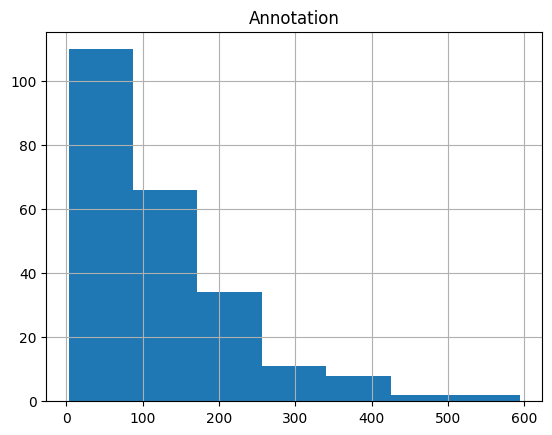

In [40]:
df.hist('Annotation', bins=7)

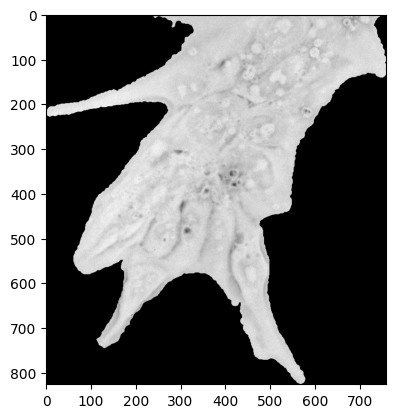

In [59]:
img = cv2.imread('images/iPSCs 004  p 15 24 h m TESR 40x 5 tif-lum.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()